In [2]:
# Notebook display settings
%pylab inline
%config InlineBackend.figure_formats = ['svg']

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# SQL library imports
import psycopg2 as pg
import pandas.io.sql as pd_sql

# Machine learning imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score,\
                            classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import RandomOverSampler, ADASYN

Populating the interactive namespace from numpy and matplotlib


# Get data from postgres

## SQL connection information

In [2]:
with open('aws_pgsql_pw.txt') as pwfile:
    password = pwfile.read()

params = {
    'host':'IP ADDRESS',
    'user':'USER NAME',
    'dbname':'flight_delays',
    'port':5432,
    'password':password
}

## Helper function to get a query from SQL

In [3]:
def sql_query(query):
    
    connection = pg.connect(**params)
    response = pd_sql.read_sql(query, connection)
    connection.close()
    return response

## Write queries for data I want

In [4]:
# Retrieve departure-time weather at destination
dest_weather_at_dep_q = """
SELECT flights.dest, flights.airline, flights.sched_depart, flights.sched_arr, flights.dep_delay,
    flights.distance, flights.arr_late,
    weather."precipProbability" AS precip_prob_dest_depart, 
    weather."precipIntensity" AS precip_int_dest_depart, 
    weather."precipType" AS precip_type_dest_depart
FROM flights
INNER JOIN weather 
ON flights.dest = weather.airport
AND flights.sched_dep_unix = weather.time;
"""

# Retrieve arrival-time weather at destination
dest_weather_at_arr_q = """
SELECT flights.dest, flights.airline, flights.sched_depart, flights.sched_arr, flights.dep_delay,
    flights.distance, flights.arr_late,
    weather."precipProbability" AS precip_prob_dest_arr, 
    weather."precipIntensity" AS precip_int_dest_arr, 
    weather."precipType" AS precip_type_dest_arr
FROM flights
INNER JOIN weather 
ON flights.dest = weather.airport
AND flights.sched_arr_unix = weather.time;
"""

# Retrieve ohare weather at departure time
ord_weather_at_dep_q = """
SELECT flights.dest, flights.airline, flights.sched_depart, flights.sched_arr, flights.dep_delay,
    flights.distance, flights.arr_late,
    weather."precipProbability" AS precip_prob_ord_depart, 
    weather."precipIntensity" AS precip_int_ord_depart, 
    weather."precipType" AS precip_type_ord_depart
FROM flights
INNER JOIN weather 
ON weather.airport = 'ORD'
AND flights.sched_dep_unix = weather.time;
"""

# Retrieve airport latitudes and longitudes
lat_lon_q = """
SELECT "AIRPORT", "LATITUDE", "LONGITUDE"
FROM airports;
"""

## Execute queries

In [5]:
airport_latlon = sql_query(lat_lon_q)

ord_dep_weather = sql_query(ord_weather_at_dep_q)

dest_dep_weather = sql_query(dest_weather_at_dep_q)

dest_arr_weather = sql_query(dest_weather_at_arr_q)

## Merge all tables

In [6]:
all_data = pd.merge(ord_dep_weather, dest_dep_weather, how='inner').merge(dest_arr_weather, how='inner')

all_data = all_data.merge(airport_latlon, left_on='dest', right_on='AIRPORT').drop(columns=['AIRPORT'])

## Format datetimes

In [7]:
all_data['sched_depart'] = all_data.sched_depart.apply(pd.to_datetime)
all_data['sched_arr'] = all_data.sched_arr.apply(pd.to_datetime)
all_data['dep_delay'] = all_data.dep_delay.apply(pd.to_timedelta).dt.seconds/60

## Add time of day and weekday
### (00-06, 06-12, 12-18, 18-00)

In [8]:
def time_of_day(time):
    
    if time.hour >= 18:
        return 4
    elif time.hour >= 12:
        return 3
    elif time.hour >= 6:
        return 2
    else:
        return 1
    
all_data['time_of_day'] = all_data.sched_depart.apply(time_of_day)

all_data['weekday'] = all_data.sched_depart.dt.weekday

# Remove outliers for departure delay

I removed the top 10% of departure delay times to try to normalize the effect of late departures a bit

In [9]:
all_data[all_data.dep_delay > 0].dep_delay.quantile(0.9)

99.0

In [10]:
all_data = all_data[all_data.dep_delay <= 99]

# EDA

## Compare delayed departures and delayed arrivals

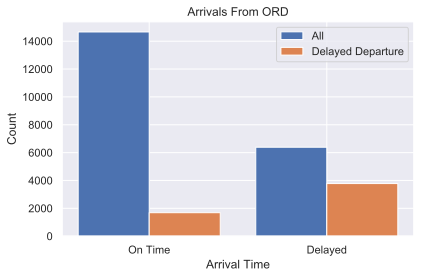

In [23]:
plt.figure()
plt.bar([-.25, 1], all_data.arr_late.value_counts(), width=0.5, label='All')
plt.bar([0.25, 1.5], all_data[all_data.dep_delay > 0].arr_late.value_counts().sort_values(), width=0.5, label='Delayed Departure')
plt.xticks(ticks=[0, 1.25], labels=['On Time', 'Delayed'], rotation=0)
plt.ylabel('Count')
plt.xlabel('Arrival Time')
plt.title('Arrivals From ORD')
plt.legend()
plt.tight_layout()
# plt.savefig('all_counts.svg');

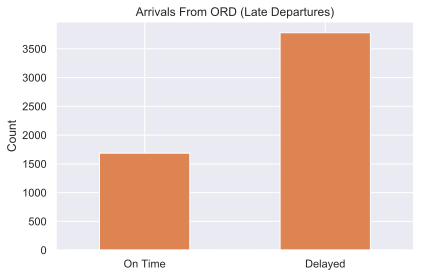

In [12]:
plt.figure()
plt.bar([0,1], [0,0])
plt.bar([0,1], all_data[all_data.dep_delay > 0].arr_late.value_counts().sort_values(), width=0.5)
plt.xticks(ticks=[0, 1], labels=['On Time', 'Delayed'], rotation=0)
plt.ylabel('Count')
plt.title('Arrivals From ORD (Late Departures)')
plt.tight_layout()
# plt.savefig('delay_dep_counts.svg');

## Look at late arrivals by airline

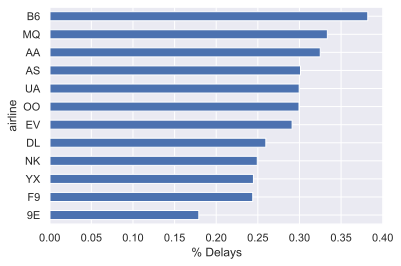

In [13]:
plt.figure()
all_data.groupby('airline').arr_late.mean().sort_values().plot(kind='barh')
plt.xlabel('% Delays');

## Plot distribution of departure delay times

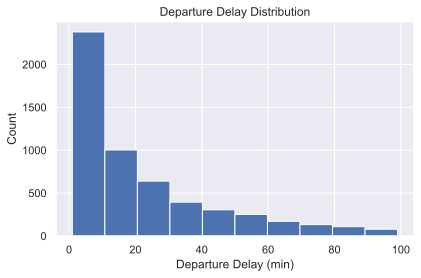

In [14]:
plt.figure()
all_data[all_data.dep_delay > 0].dep_delay.hist()
plt.xlabel('Departure Delay (min)')
plt.ylabel('Count')
plt.title('Departure Delay Distribution')
plt.tight_layout()
# plt.savefig('dep_delays.svg');

# Modeling

This is a function to help test multiple models quickly. With a given input model, the function will fit on the train set and output metrics on the train set and the test set

In [16]:
def eval_model(model):
    
    model.fit(X_train, y_train)
    
    print('IN SAMPLE:')
    print(classification_report(y_train, model.predict(X_train)))
    print(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    print(confusion_matrix(y_train, model.predict(X_train)))
    
    print('---------\nOUT OF SAMPLE:')
    print(classification_report(y_test, model.predict(X_test)))
    print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print(confusion_matrix(y_test, model.predict(X_test)))

## Separate train and test sets for all data

In [17]:
X = all_data.drop(['dest', 'sched_depart', 'sched_arr', 'arr_late', 'airline', 'distance']
                  +[c for c in all_data.columns if 'type' in c or 'ord' in c or 'int' in c], axis=1)
y = all_data.arr_late

X_TR_MASTER, X_TE_MASTER, Y_TR_MASTER, Y_TE_MASTER = train_test_split(X, y, test_size=0.2, random_state=12)

## Try one hero model

### Random forest works a bit better than logistic regression here 

### Perform a 5-fold cross validation with a random forest to tune hyperparameters and reduce overfitting

#### ADASYN oversampling was used to account for imbalanced classes

In [18]:
acc_scores = []
auc_scores = []
precision_scores = []
recall_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

for train_ind, test_ind in kf.split(X_TR_MASTER, Y_TR_MASTER):
    
    X_tr, y_tr = X_TR_MASTER.iloc[train_ind], Y_TR_MASTER.iloc[train_ind]
    X_te, y_te = X_TR_MASTER.iloc[test_ind], Y_TR_MASTER.iloc[test_ind]
    
    X_tr, y_tr = ADASYN(random_state=12).fit_sample(X_tr, y_tr)
    
    rf = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=100)
    rf.fit(X_tr, y_tr)
    
    acc_scores.append(rf.score(X_te, y_te))
    auc_scores.append(roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))
    precision_scores.append(precision_score(y_te, rf.predict(X_te)))
    recall_scores.append(recall_score(y_te, rf.predict(X_te)))

print('***** Random Forest CV *****')
print(f'Mean Accuracy Score: {np.mean(acc_scores)}')
print(f'Mean ROC AUC Score: {np.mean(auc_scores)}')
print(f'Mean Precision Score: {np.mean(precision_scores)}')
print(f'Mean Recall Score: {np.mean(recall_scores)}')

***** Random Forest CV *****
Mean Accuracy Score: 0.8045026865058466
Mean ROC AUC Score: 0.8148951377514864
Mean Precision Score: 0.7099027648412467
Mean Recall Score: 0.6021914747500253


### Compare with dummy classifier

In [19]:
X_res_all, y_res_all = ADASYN(random_state=12).fit_sample(X_TR_MASTER, Y_TR_MASTER)

rf_all = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=100)
rf_all.fit(X_res_all, y_res_all)

print('***** RANDOM FOREST *****\n')
print(f'ROC AUC: {roc_auc_score(Y_TR_MASTER, rf_all.predict_proba(X_TR_MASTER)[:,1])}\n')
print(classification_report(Y_TR_MASTER, rf_all.predict(X_TR_MASTER)))

dummy = DummyClassifier()
dummy.fit(X_TR_MASTER, Y_TR_MASTER)

print('***** DUMMY CLASSIFIER *****\n')
print(f'ROC AUC: {roc_auc_score(Y_TR_MASTER, dummy.predict_proba(X_TR_MASTER)[:,1])}')
print(classification_report(Y_TR_MASTER, dummy.predict(X_TR_MASTER)))

***** RANDOM FOREST *****

ROC AUC: 0.859299805631013

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11726
           1       0.78      0.64      0.70      5113

    accuracy                           0.84     16839
   macro avg       0.82      0.78      0.80     16839
weighted avg       0.83      0.84      0.83     16839

***** DUMMY CLASSIFIER *****

ROC AUC: 0.5007375610369891
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     11726
           1       0.30      0.31      0.30      5113

    accuracy                           0.57     16839
   macro avg       0.50      0.50      0.50     16839
weighted avg       0.58      0.57      0.57     16839



### Check ROC and confusion matrix

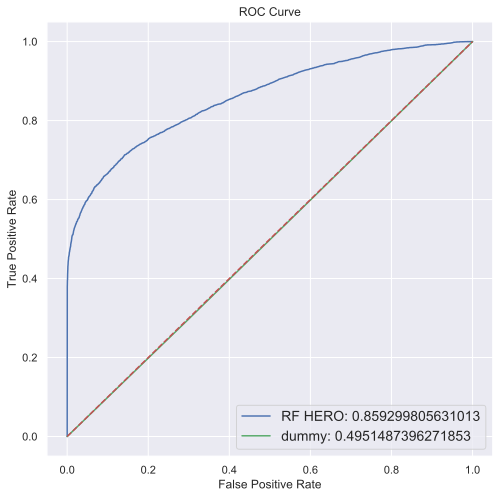

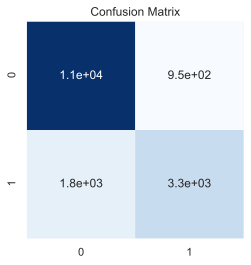

In [20]:
rf_all_roc = roc_curve(Y_TR_MASTER, rf_all.predict_proba(X_TR_MASTER)[:,1])
dum_roc = roc_curve(Y_TR_MASTER, dummy.predict_proba(X_TR_MASTER)[:,1])

plt.figure(figsize=(8,8))
plt.plot(rf_all_roc[0], rf_all_roc[1], label=f'RF HERO: {roc_auc_score(Y_TR_MASTER, rf_all.predict_proba(X_TR_MASTER)[:,1])}')
plt.plot(dum_roc[0], dum_roc[1], c='g', label=f'dummy: {roc_auc_score(Y_TR_MASTER, dummy.predict_proba(X_TR_MASTER)[:,1])}')
plt.plot([0,1],[0,1], 'r--')
plt.legend(fontsize=14)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

plt.figure()
sns.heatmap(confusion_matrix(Y_TR_MASTER, rf_all.predict(X_TR_MASTER)), cmap=plt.cm.Blues, annot=True, square=True, cbar=False)
plt.title('Confusion Matrix');

## Try separate models for late departures and on-time departures

### Separate out flights that departed late to use in a different model

In [21]:
X_tr_late = X_TR_MASTER[X_TR_MASTER.dep_delay > 0]
y_tr_late = Y_TR_MASTER.loc[X_tr_late.index]

X_tr_ot = X_TR_MASTER[X_TR_MASTER.dep_delay == 0].drop(columns=['dep_delay'])
y_tr_ot = Y_TR_MASTER.loc[X_tr_ot.index]

### Choose a model for flights that don't leave late

#### I'll use a random forest here, with oversampling to make up for class imbalance

In [22]:
acc_scores = []
auc_scores = []
precision_scores = []
recall_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

for train_ind, test_ind in kf.split(X_tr_ot, y_tr_ot):
    
    X_tr, y_tr = X_tr_ot.iloc[train_ind], y_tr_ot.iloc[train_ind]
    X_te, y_te = X_tr_ot.iloc[test_ind], y_tr_ot.iloc[test_ind]
    
    X_tr, y_tr = ADASYN(random_state=12).fit_sample(X_tr, y_tr)
    
    rf = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=100)
    rf.fit(X_tr, y_tr)
    
    acc_scores.append(rf.score(X_te, y_te))
    auc_scores.append(roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))
    precision_scores.append(precision_score(y_te, rf.predict(X_te)))
    recall_scores.append(recall_score(y_te, rf.predict(X_te)))

print('***** Random Forest CV *****')
print(f'Mean Accuracy Score: {np.mean(acc_scores)}')
print(f'Mean ROC AUC Score: {np.mean(auc_scores)}')
print(f'Mean Precision Score: {np.mean(precision_scores)}')
print(f'Mean Recall Score: {np.mean(recall_scores)}')

***** Random Forest CV *****
Mean Accuracy Score: 0.7915204132467244
Mean ROC AUC Score: 0.6394990316223188
Mean Precision Score: 0.3275180484343226
Mean Recall Score: 0.23931533827618168


#### Compare with dummy classifier

In [23]:
X_res_ot, y_res_ot = ADASYN(random_state=12).fit_sample(X_tr_ot, y_tr_ot)

rf_ot = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=100).fit(X_res_ot, y_res_ot)

dummy = DummyClassifier().fit(X_tr_ot, y_tr_ot)

print('***** RANDOM FOREST *****\n')
print(f'ROC AUC: {roc_auc_score(y_tr_ot, rf_ot.predict_proba(X_tr_ot)[:,1])}\n')
print(classification_report(y_tr_ot, rf_ot.predict(X_tr_ot)))

print('***** DUMMY CLASSIFIER *****\n')
print(f'ROC AUC: {roc_auc_score(y_tr_ot, dummy.predict_proba(X_tr_ot)[:,1])}\n')
print(classification_report(y_tr_ot, dummy.predict(X_tr_ot)))

***** RANDOM FOREST *****

ROC AUC: 0.7429169736239131

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     10375
           1       0.41      0.39      0.40      2077

    accuracy                           0.81     12452
   macro avg       0.64      0.64      0.64     12452
weighted avg       0.80      0.81      0.80     12452

***** DUMMY CLASSIFIER *****

ROC AUC: 0.5018010917043233

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     10375
           1       0.16      0.16      0.16      2077

    accuracy                           0.72     12452
   macro avg       0.50      0.50      0.50     12452
weighted avg       0.72      0.72      0.72     12452



#### Check ROC and confusion matrix

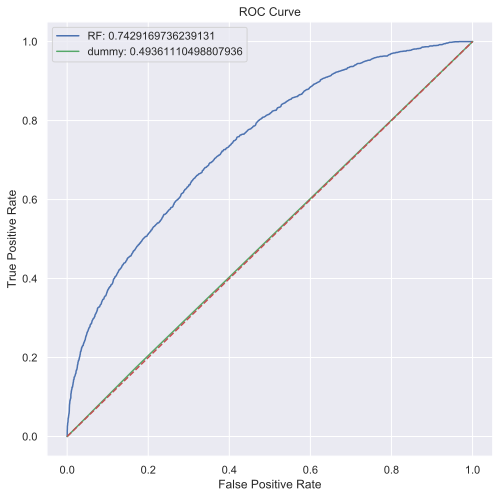

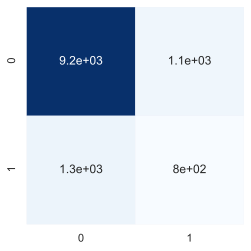

In [24]:
ot_roc = roc_curve(y_tr_ot, rf_ot.predict_proba(X_tr_ot)[:,1])
dum_roc = roc_curve(y_tr_ot, dummy.predict_proba(X_tr_ot)[:,1])

plt.figure(figsize=(8,8))
plt.plot(ot_roc[0], ot_roc[1], label=f'RF: {roc_auc_score(y_tr_ot, rf_ot.predict_proba(X_tr_ot)[:,1])}')
plt.plot(dum_roc[0], dum_roc[1], c='g', label=f'dummy: {roc_auc_score(y_tr_ot, dummy.predict_proba(X_tr_ot)[:,1])}')
plt.plot([0,1],[0,1], 'r--')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

plt.figure()
sns.heatmap(confusion_matrix(y_tr_ot, rf_ot.predict(X_tr_ot)), cmap=plt.cm.Blues, annot=True, square=True, cbar=False);

### Choose a model for flights that do leave late

#### Random forest also worked best here, but this time without oversampling

In [25]:
acc_scores = []
auc_scores = []
precision_scores = []
recall_scores = []

from collections import Counter

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

for train_ind, test_ind in kf.split(X_tr_late, y_tr_late):
    
    X_tr, y_tr = X_tr_late.iloc[train_ind], y_tr_late.iloc[train_ind]
    X_te, y_te = X_tr_late.iloc[test_ind], y_tr_late.iloc[test_ind]
    
    rf = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=10)
    rf.fit(X_tr, y_tr)
    
    acc_scores.append(rf.score(X_te, y_te))
    auc_scores.append(roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))
    precision_scores.append(precision_score(y_te, rf.predict(X_te)))
    recall_scores.append(recall_score(y_te, rf.predict(X_te)))

print('***** Random Forest CV *****')
print(f'Mean Accuracy Score: {np.mean(acc_scores)}')
print(f'Mean ROC AUC Score: {np.mean(auc_scores)}')
print(f'Mean Precision Score: {np.mean(precision_scores)}')
print(f'Mean Recall Score: {np.mean(recall_scores)}')

***** Random Forest CV *****
Mean Accuracy Score: 0.774791764768454
Mean ROC AUC Score: 0.8514358839972328
Mean Precision Score: 0.8430975907658143
Mean Recall Score: 0.8290552111332697


#### Compare with dummy classifier

In [26]:
rf_late = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=10).fit(X_tr_late, y_tr_late)

print('***** RANDOM FOREST *****\n')
print(f'ROC AUC: {roc_auc_score(y_tr_late, rf_late.predict_proba(X_tr_late)[:,1])}\n')
print(classification_report(y_tr_late, rf_late.predict(X_tr_late)))

dummy = DummyClassifier()
dummy.fit(X_tr_late, y_tr_late)
print('***** DUMMY CLASSIFIER *****\n')
print(f'ROC AUC: {roc_auc_score(y_tr_late, dummy.predict_proba(X_tr_late)[:,1])}\n')
print(classification_report(y_tr_late, dummy.predict(X_tr_late)))

***** RANDOM FOREST *****

ROC AUC: 0.94559536731197

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1351
           1       0.93      0.88      0.91      3036

    accuracy                           0.87      4387
   macro avg       0.85      0.87      0.86      4387
weighted avg       0.88      0.87      0.88      4387

***** DUMMY CLASSIFIER *****

ROC AUC: 0.49713224186641625

              precision    recall  f1-score   support

           0       0.31      0.32      0.31      1351
           1       0.69      0.69      0.69      3036

    accuracy                           0.57      4387
   macro avg       0.50      0.50      0.50      4387
weighted avg       0.58      0.57      0.57      4387



#### Check ROC and confusion matrix

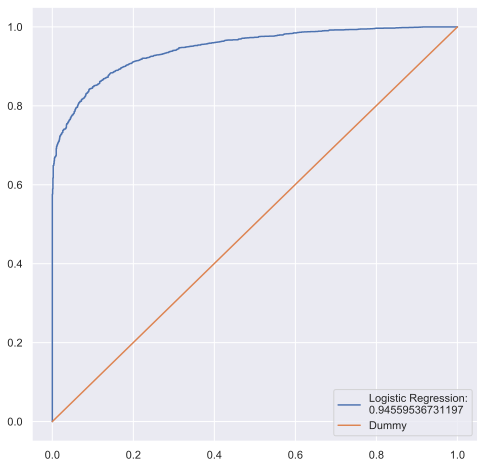

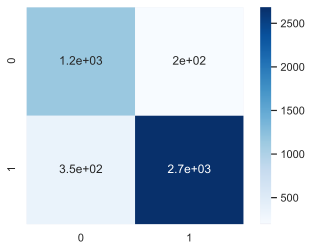

In [27]:
late_roc = roc_curve(y_tr_late, rf_late.predict_proba(X_tr_late)[:,1])
dummy_roc = roc_curve(y_tr_late, dummy.predict_proba(X_tr_late)[:,1])

plt.figure(figsize=(8,8))
plt.plot(late_roc[0], late_roc[1], label=f'Logistic Regression:\n{roc_auc_score(y_tr_late, rf_late.predict_proba(X_tr_late)[:,1])}')
plt.plot(dummy_roc[0], dummy_roc[1], label='Dummy')
plt.legend();

plt.figure()
sns.heatmap(confusion_matrix(y_tr_late, rf_late.predict(X_tr_late)), cmap=plt.cm.Blues, annot=True, square=True);

### Combine two models

In [28]:
X_res_ot, y_res_ot = ADASYN(random_state=12).fit_sample(X_tr_ot, y_tr_ot)
otdep_model = RandomForestClassifier(max_depth=10, random_state=12, n_estimators=100)
otdep_model.fit(X_res_ot, y_res_ot)

latedep_model = RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=12, n_estimators=10)
latedep_model.fit(X_tr_late, y_tr_late)

def combo_predict(X):
    
    X_late = X[X.dep_delay > 0]
    late_ind = X_late.index
    
    X_ot = X[X.dep_delay == 0].drop(columns=['dep_delay'])
    ot_ind = X_ot.index
    
    late_pred = pd.Series(latedep_model.predict(X_late))
    ot_pred = pd.Series(otdep_model.predict(X_ot))
    pred_all = late_pred.append(ot_pred)
        
    return pred_all, late_ind, ot_ind
    
    
def combo_predict_proba(X):
    X_late = X[X.dep_delay > 0]
    late_ind = X_late.index
    
    X_ot = X[X.dep_delay == 0].drop(columns=['dep_delay'])
    ot_ind = X_ot.index
    
    late_proba = pd.Series(latedep_model.predict_proba(X_late)[:,1])
    ot_proba = pd.Series(otdep_model.predict_proba(X_ot)[:,1])
    proba_all = late_proba.append(ot_proba)
        
    return proba_all, late_ind, ot_ind
    

# Check all models on holdout

Compare the predictions of the split model, the dummy model, and the single "hero" model.

I updated the positive prediction threshold of the "hero" model to be 0.45, so it will predict a delay at 45% predicted probability

***** DUMMY CLASSIFIER *****

ROC AUC: 0.5005755970382284

              precision    recall  f1-score   support

           0       0.70      0.31      0.43      2936
           1       0.30      0.68      0.42      1274

    accuracy                           0.42      4210
   macro avg       0.50      0.50      0.42      4210
weighted avg       0.58      0.42      0.43      4210

***** COMBO MODEL *****

ROC AUC: 0.7985474529363202

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2936
           1       0.63      0.62      0.62      1274

    accuracy                           0.77      4210
   macro avg       0.73      0.73      0.73      4210
weighted avg       0.77      0.77      0.77      4210


***** SINGLE RANDOM FOREST *****

ROC AUC: 0.8185322730014244

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2936
           1       0.66      0.62      0.64      1274

    a

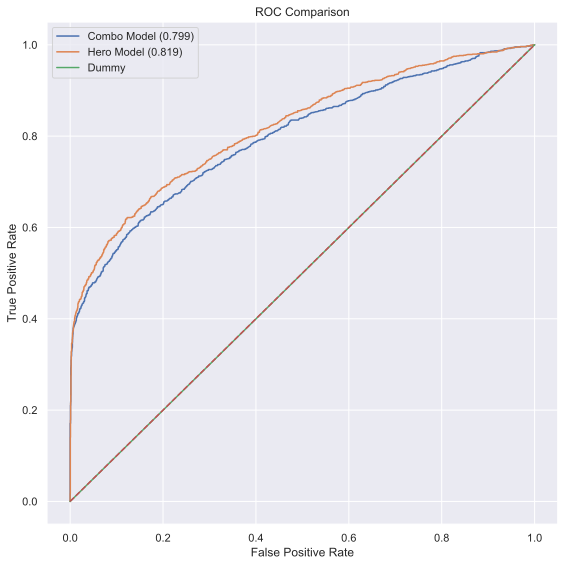

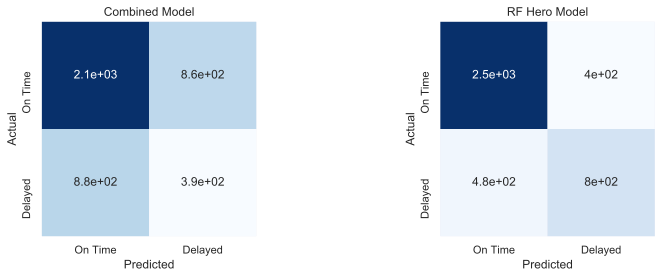

In [29]:
# Generate dual-model predictions
pred, late_ind, ot_ind = combo_predict(X_TE_MASTER)
y_test = pd.concat([Y_TE_MASTER.loc[late_ind], Y_TE_MASTER.loc[ot_ind]])

pred_proba = combo_predict_proba(X_TE_MASTER)[0]

# Use dummy model
dummy_final = DummyClassifier().fit(X_TR_MASTER, Y_TR_MASTER)
dummy_pred = dummy.predict(X_TE_MASTER)

print('***** DUMMY CLASSIFIER *****\n')
print(f'ROC AUC: {roc_auc_score(Y_TE_MASTER, dummy_final.predict_proba(X_TE_MASTER)[:,1])}\n')
print(classification_report(Y_TE_MASTER, dummy_pred))

print('***** COMBO MODEL *****\n')
print(f'ROC AUC: {roc_auc_score(y_test, pred_proba)}\n')
print(classification_report(y_test, pred))

print('\n***** SINGLE RANDOM FOREST *****\n')
print(f'ROC AUC: {roc_auc_score(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1])}\n')
print(classification_report(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1]>=0.45))

roc_dummy = roc_curve(Y_TE_MASTER, dummy_final.predict_proba(X_TE_MASTER)[:,1])
roc_combo = roc_curve(y_test, pred_proba)
roc_single = roc_curve(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1])
plt.figure(figsize=(8, 8))
plt.plot(roc_combo[0], roc_combo[1], label=f'Combo Model ({roc_auc_score(y_test, pred_proba):.3f})')
plt.plot(roc_single[0], roc_single[1], label=f'Hero Model ({roc_auc_score(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1]):.3f})')
plt.plot(roc_dummy[0], roc_dummy[1], label='Dummy')
plt.plot([0,1],[0,1],'r--')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.tight_layout()
# plt.savefig('roc_compare.svg');

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(confusion_matrix(Y_TE_MASTER, pred), cmap=plt.cm.Blues, annot=True,
            square=True, ax=ax[0], cbar=False,
            xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Combined Model')

sns.heatmap(confusion_matrix(Y_TE_MASTER, (rf_all.predict_proba(X_TE_MASTER)[:,1]>=0.45).astype(int)),
            cmap=plt.cm.Blues, annot=True, square=True, ax=ax[1], cbar=False,
            xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('RF Hero Model')
plt.tight_layout()
# plt.savefig('confusion_compare.svg');

# Final Model Selection

After comparing all the options, I will use a single random forest as my model.

I had hoped that manually splitting on delayed departure could help the model make better predictions for flights that left on time, but it looks like the single hero model is the best solution at this point.

I played around with changing the probability threshold for predicting positive, and the best result ended up using a threshold of 45%

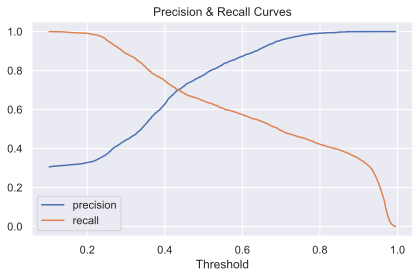

In [30]:
from sklearn.metrics import precision_recall_curve

pr = precision_recall_curve(Y_TR_MASTER, rf_all.predict_proba(X_TR_MASTER)[:,1])

plt.figure()
plt.plot(pr[2], pr[0][1:], label='precision')
plt.plot(pr[2], pr[1][1:], label='recall')
plt.xlabel('Threshold')
plt.title('Precision & Recall Curves')
plt.legend()
plt.tight_layout()
# plt.savefig('./noah_project_3/hero_pr_curves.svg');

Text(0.5, 1, 'RF Hero Model')

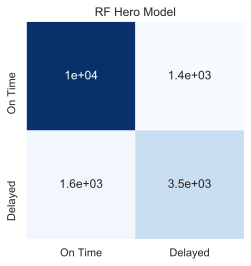

In [31]:
plt.figure()
sns.heatmap(confusion_matrix(Y_TR_MASTER, (rf_all.predict_proba(X_TR_MASTER)[:,1]>=0.45).astype(int)),
            cmap=plt.cm.Blues, annot=True, square=True, cbar=False,
            xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.title('RF Hero Model')
# plt.savefig('hero_confusion_matrix.svg');

Looking at the precision/recall curves and the confusion matrix led me to choose an optimal threshold of 0.45.

0.8185322730014244
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2936
           1       0.66      0.62      0.64      1274

    accuracy                           0.79      4210
   macro avg       0.75      0.74      0.75      4210
weighted avg       0.79      0.79      0.79      4210



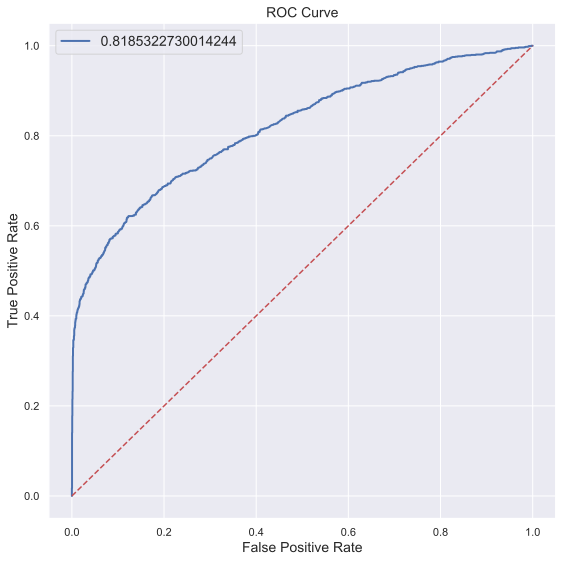

In [32]:
final_pred = rf_all.predict_proba(X_TE_MASTER)[:,1]>=0.45

print(roc_auc_score(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1]))
print(classification_report(Y_TE_MASTER, final_pred))

final_roc = roc_curve(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1])

plt.figure(figsize=(8,8))
plt.plot(final_roc[0], final_roc[1], lw=2, label=roc_auc_score(Y_TE_MASTER, rf_all.predict_proba(X_TE_MASTER)[:,1]))
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig('final_roc.svg');

## Look at feature importances

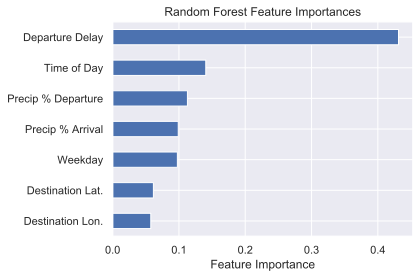

In [33]:
plt.figure()
importances = pd.Series(dict(zip(X.columns, rf_all.feature_importances_))).sort_values()
# importances.index = ['Departure Delay', 'Time Of Day', 'Precip % Departure', 'Precip % Arrival',
#                 'Weekday', 'Destination Lat.', 'Destination Lon.']
importances.index = ['Destination Lon.', 'Destination Lat.', 'Weekday', 'Precip % Arrival',
                    'Precip % Departure', 'Time of Day', 'Departure Delay']
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
# plt.savefig('feat_imp.svg');

# Generate data for viz

This code was used to generate a table of predicted delays using all combinations of all parameters. This table was input into a map in Tableau to best visualize the results of the model.

In [34]:
import itertools

coords = X.loc[:,['LATITUDE','LONGITUDE']].drop_duplicates().values
delays = np.arange(0, 20, 1)
dests = all_data.dest.unique()
precip_arr = np.arange(0, 1.1, .25)
precip_dep = np.arange(0, 1.1, .25)
times = np.arange(1, 5)
weekdays = np.arange(0, 7)

l = [delays, precip_dep, precip_arr, times, weekdays, coords]

viz = pd.DataFrame(list(itertools.product(*l)), columns=['dep_delay', 'precip_prob_dest_depart',
                                                         'precip_prob_dest_arr', 'time_of_day',
                                                         'weekday', 'coords'])
viz = pd.concat([viz, pd.DataFrame(viz.coords.values.tolist(), columns=['LATITUDE', 'LONGITUDE'])], axis=1)
viz = viz.drop('coords', axis=1)
viz = viz.loc[:, ['dep_delay', 'precip_prob_dest_depart', 'precip_prob_dest_arr',
                  'LATITUDE', 'LONGITUDE', 'time_of_day', 'weekday']]

# viz['time_of_day'] = viz.time_of_day.replace({1:'00:00-06:00', 2:'06:00-12:00', 3:'12:00-18:00', 4:'18:00-00:00'})
# viz['weekday'] = viz.weekday.replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
#                                      4:'Friday', 5:'Saturday', 6:'Sunday'})
# viz['arr_late'] = rf_all.predict(viz)
viz['arr_late_proba'] = rf_all.predict_proba(viz)[:,1]
viz['arr_late'] = (viz.arr_late_proba >= 0.45).astype(int)

# viz.to_csv('viz_pred.csv', index=False)